In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

2024-04-12 12:19:06.745161: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('/Users/blotenko/Downloads/Diamonds Prices2022.csv')

In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df['dimensions'] = df['x'] * df['y'] * df['z']
df = df[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'dimensions', 'price']]
labelencoder = LabelEncoder()
df['cut'] = labelencoder.fit_transform(df['cut'])
df['color'] = labelencoder.fit_transform(df['color'])
df['clarity'] = labelencoder.fit_transform(df['clarity'])

In [6]:
X = df.drop(['price'], axis=1)
y = df['price']

In [7]:
X.head()

,carat,cut,color,clarity,depth,table,dimensions
0,0.23,2,1,3,61.5,55.0,38.202030
1,0.21,3,1,2,59.8,61.0,34.505856
2,0.23,1,1,4,56.9,65.0,38.076885
3,0.29,3,5,5,62.4,58.0,46.724580
4,0.31,1,6,3,63.3,58.0,51.917250


In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [10]:

X_train.shape

(34523, 7)

In [11]:
y_train = y_train.to_numpy().reshape(-1)

In [12]:
y_train.shape

(34523,)

In [30]:
K = keras.backend


class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_end(self, epoch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

        

In [31]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [32]:
model = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="relu")
])

In [33]:
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-3))
expon_lr = ExponentialLearningRate(factor=1.005)

In [36]:
expon_lr = ExponentialLearningRate(factor=1.005)

history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_val, y_val),
                    callbacks=[expon_lr])

1024/1079 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 1693243.3750

AttributeError: 'str' object has no attribute 'name'

/var/folders/c0/lp6fsf85619cwnsnctss5nd00000gn/T/ipykernel_91632/2891158959.py:4: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])


Text(0, 0.5, 'Loss')

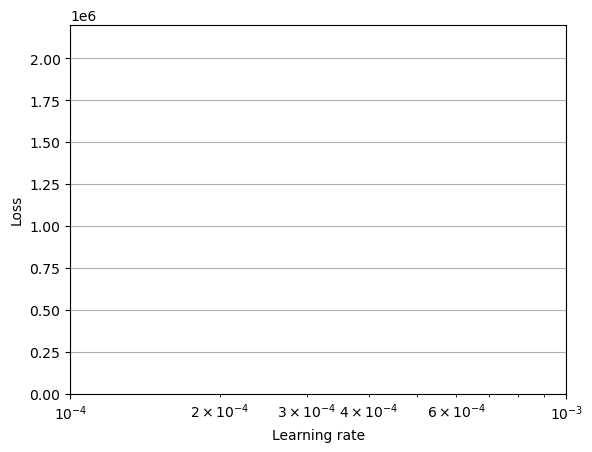

In [39]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [40]:
run_index = 1
run_logdir = os.path.join(os.curdir, "my_diamonts_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_diamonts_logs/run_001'

In [41]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
model = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="relu")
])

In [43]:
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=5e-4))
expon_lr = ExponentialLearningRate(factor=1.005)

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_diamonds_model.keras", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 13091673.0000 - val_loss: 2176695.2500
Epoch 2/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2257062.2500 - val_loss: 2128920.2500
Epoch 3/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2109940.7500 - val_loss: 2005662.3750
Epoch 4/100
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1972993.3750 - val_loss: 1870892.3750
Epoch 5/100
 175/1079 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1882486.5000

In [ ]:
model = keras.models.load_model("best_diamonts_model.h5")  # rollback to best model
model.evaluate(X_test, y_test)

In [49]:
%load_ext tensorboard

In [ ]:

%tensorboard --logdir=./my_diamonts_logs --port=6006

Launching TensorBoard...